**deepSISOCSIT**<br>
by $\text{Rishabh Pomaje}$

- Autoencoder based SISO system with perfect CSI available at both the transmitter and the receiver.
- Objectives :
    - To learn a (4, 7) system under the following conditions:
        1. Flat-fading, fast fading
        2. Rayleigh Channel with AWGN
        3. Channel Model : $y_i = h_i x_i + w_i$
            - where, $h \overset{i.i.d}{\sim} \mathcal{CN}(0, 1)$ and $w \overset{i.i.d}{\sim} \mathcal{CN}(0, N_0)$

**Definitions**
\begin{equation}
    \text{SNR}_{linear} = \text{Signal-to-noise power ratio per symbol time} = \frac{E_b}{2N_0}
\end{equation}
Consider,
\begin{equation*}
    \frac{1}{2 \times SNR_{linear}} = \frac{1 \times 2N_0}{2 \times E_b} = \frac{N_0}{a} = N_0 \;\dots (a = 1) 
\end{equation*}

Also, 

\begin{equation*}
\frac{1}{2 \times R \times SNR_{linear}} = \frac{1 \times n \times N_0}{2 \times k \times E_b} = \frac{nN_0}{2k}
\end{equation*}

In [55]:
# Dependencies :
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf 
%config InlineBackend.figure_format='svg'
TF_ENABLE_ONEDNN_OPTS = 0 
print(tf.__version__)

2.16.1


- We are restraining to using only BPSK mapping
We define SNR as follows :
\begin{equation}
\text{SNR}_{linear} = \frac{E_b}{N_0} = \frac{\text{Received signal energy per bit}}{\text{Noise Spectral density}}
\end{equation}
- Per bit energies :
- BPSK : {$\pm \sqrt{E_{b}}$}
- $E_{uncoded} = 1 $
\begin{equation}
E_{coded} = E_{uncoded} \times k / n = E_{uncoded} \times R
\end{equation}
- $R$ = Information Rate 
- $\color{red}{Note}$ : This difference in energy per bit needs to be compensated in either symbol energy or the noise variance. I have arbitrarily chosen it to be the noise variance.

System Specifications/ Parameters/ Definitions 

In [56]:
k = 4           # Uncoded block length       
n = 7           # Codeword length 
M = 2 ** 4      # Size of the alphabet 
R = k / n       # Information rate 

Generating the training data 

In [57]:
training_set_size = 10 ** 6

# Random indices 
samples_indices = np.random.randint(0, M, training_set_size)

# Converting the indices to 1-hot vectors
x_train = np.zeros((training_set_size, M))
x_train[np.arange(training_set_size), samples_indices] = 1

# We wish to reconstruct the input at the output
y_train = x_train

# Generate random fading taps for training == CSI @ Tx + Rx
fade_mean = 0 
fade_std = np.sqrt(0.5)
fade_taps_real = np.random.normal(fade_mean, fade_std, (training_set_size, n))
fade_taps_imag = np.random.normal(fade_mean, fade_std, (training_set_size, n))

Creating the Autoencoder

In [58]:
# Encoder Layers :: (Transmitter)
enc_bits_input_layer = tf.keras.Input(shape=(M, ), name="Bits_Input_Layer")
enc_csi_input_I = tf.keras.Input(shape=(n, ), name='Fading_Input_Layer_real')
enc_csi_input_Q = tf.keras.Input(shape=(n, ), name='Fading_Input_Layer_imag')
enc_combined_input = tf.keras.layers.Concatenate()([enc_bits_input_layer, enc_csi_input_I, enc_csi_input_Q])

enc_layer_01 = tf.keras.layers.Dense(M + 2*n, activation='relu', name="Encoder_Hidden_01")(enc_combined_input)
enc_layer_02 = tf.keras.layers.Dense(n, activation='relu', name="Encoder_Hidden_02")(enc_layer_01)
enc_layer_03 = tf.keras.layers.Dense(n, activation='linear', name="Encoder_Hidden_03")(enc_layer_02)
enc_layer_normalized = tf.keras.layers.Lambda((lambda x : np.sqrt(n) * tf.keras.backend.l2_normalize(x, axis=-1)), name='Power_Constraint')(enc_layer_03)

# Channel Layers :: Rayleigh Fading + AWGN 
faded_signal_I = tf.keras.layers.Multiply()([enc_csi_input_I, enc_layer_normalized])
faded_signal_Q = tf.keras.layers.Multiply()([enc_csi_input_Q, enc_layer_normalized])
# Adding the noise 
SNR_dB = 7
SNR_lin = 10 ** (SNR_dB / 10)
noisy_signal_I = tf.keras.layers.GaussianNoise(stddev=np.sqrt(1 / (2 * R * SNR_lin)), name='AWGN_channel_I')(faded_signal_I)
noisy_signal_Q = tf.keras.layers.GaussianNoise(stddev=np.sqrt(1 / (2 * R * SNR_lin)), name='AWGN_channel_Q')(faded_signal_Q)

# Decoder Layers :: (Receiver)
rx_signal = tf.keras.layers.Concatenate()([noisy_signal_I, noisy_signal_Q, enc_csi_input_I, enc_csi_input_Q])
dec_layer_01 = tf.keras.layers.Dense(4*M, activation='relu', name="Decoder_layer_01")(rx_signal)
dec_layer_02 = tf.keras.layers.Dense(2*M, activation='relu', name="Decoder_layer_02")(dec_layer_01)
dec_output_layer = tf.keras.layers.Dense(M, activation='softmax', name="Output_layer")(dec_layer_02)

# rx_signal = tf.keras.layers.Concatenate()([noisy_signal_I, noisy_signal_Q, enc_csi_input_I, enc_csi_input_Q])
# dec_layer_01 = tf.keras.layers.Dense(4*M, activation='relu', name="Decoder_layer_01")(rx_signal)
# dec_layer_02 = tf.keras.layers.Dense(M, activation='relu', name="Decoder_layer_02")(dec_layer_01)
# dec_output_layer = tf.keras.layers.Dense(M, activation='softmax', name="Output_layer")(dec_layer_02)


autoencoder = tf.keras.Model(
                    inputs = [enc_bits_input_layer, enc_csi_input_I, enc_csi_input_Q],
                    outputs = [dec_output_layer]
                )

# Compiling the model :
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
autoencoder.summary()

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Fading_Input_Layer… │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Bits_Input_Layer    │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Fading_Input_Layer… │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 30)        │          0 │ Bits_Input_Layer… │
│ (Concatenate)       │                   │            │ Fading_Input_Lay… │
│                     │                   │            │ Fading_Input_Lay… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_Hidden_01   │ (None, 30)        │        930 │ concatenate_12[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_Hidden_02   │ (None, 7)         │        217 │ Encoder_Hidden_0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_Hidden_03   │ (None, 7)         │         56 │ Encoder_Hidden_0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Power_Constraint    │ (None, 7)         │          0 │ Encoder_Hidden_0… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_12         │ (None, 7)         │          0 │ Fading_Input_Lay… │
│ (Multiply)          │                   │            │ Power_Constraint… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_13         │ (None, 7)         │          0 │ Fading_Input_Lay… │
│ (Multiply)          │                   │            │ Power_Constraint… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AWGN_channel_I      │ (None, 7)         │          0 │ multiply_12[0][0] │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AWGN_channel_Q      │ (None, 7)         │          0 │ multiply_13[0][0] │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (None, 28)        │          0 │ AWGN_channel_I[0… │
│ (Concatenate)       │                   │            │ AWGN_channel_Q[0… │
│                     │                   │            │ Fading_Input_Lay… │
│                     │                   │            │ Fading_Input_Lay… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_layer_01    │ (None, 64)        │      1,856 │ concatenate_13[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_layer_02    │ (None, 32)        │      2,080 │ Decoder_layer_01… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_layer        │ (None, 16)        │        528 │ Decoder_layer_02

 Total params: 5,667 (22.14 KB)

 Trainable params: 5,667 (22.14 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
# tf.keras.utils.plot_model(
#     autoencoder,
#     to_file='images/deepSISOCSIT.png',
#     show_shapes=True,
#     show_dtype=True,
#     show_layer_names=True,
#     rankdir='TB',
#     expand_nested=True,
#     dpi=200,
#     show_layer_activations=True,
#     show_trainable=True,
# )

Training the above autoencoder

In [60]:
autoencoder.fit([x_train, fade_taps_real, fade_taps_imag], y_train, batch_size=1000, epochs=250)

Epoch 1/1000
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.2340 - loss: 2.1204
Epoch 2/1000
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7408 - loss: 0.6584
Epoch 3/1000
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8375 - loss: 0.4292
Epoch 4/1000
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8603 - loss: 0.3723
Epoch 5/1000
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8843 - loss: 0.3148
Epoch 6/1000
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.9097 - loss: 0.2490
Epoch 7/1000
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9178 - loss: 0.2266
Epoch 8/1000
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.9223 - loss: 0.2144
Epoch 9/1000
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9256 - loss: 0.2062
Epoch 10/1000
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9272 - loss: 0.2014
Epoch 11/1000
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9291 - loss: 0.1963
Ep

Testing the above trained autoencoder at varying SNR levels

Generating the testing/ validation data

In [61]:
testing_data_size = 10 ** 6
y_test = np.random.randint(0, M, testing_data_size)
x_test = np.zeros((testing_data_size, M))  
x_test[np.arange(testing_data_size), y_test] = 1  # One-hot encoding

x_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [62]:
# Abstracting the encoder :
encoder_model = tf.keras.Model([enc_bits_input_layer, enc_csi_input_I, enc_csi_input_Q], enc_layer_normalized)

# Abstracting out the decoder :
signal_at_rx_I = tf.keras.Input(shape=(n,))
signal_at_rx_Q = tf.keras.Input(shape=(n,))
csi_at_rx_I = tf.keras.Input(shape=(n,))
csi_at_rx_Q = tf.keras.Input(shape=(n,))
decoder_output = autoencoder.layers[-4]([signal_at_rx_I, signal_at_rx_Q, csi_at_rx_I, csi_at_rx_Q])
decoder_output = autoencoder.layers[-3](decoder_output)
decoder_output = autoencoder.layers[-2](decoder_output)
decoder_output = autoencoder.layers[-1](decoder_output)

decoder_model = tf.keras.Model([signal_at_rx_I, signal_at_rx_Q, csi_at_rx_I, csi_at_rx_Q], decoder_output)


Validation Routine

In [63]:
# Range of Signal to Noise Ratio :
# in dB :
SNR_dB = np.linspace(-2, 20, 30)
# in Linear Scale :
SNR_lin = 10 ** (SNR_dB / 10)
# Fixing energy per bit :
E_b = 1 
# Range of noise variance accordingly :
noise_var = 1 / (2 * R * SNR_lin)

In [64]:
BLER_learned_coded_csit = []
for noise in noise_var:
    # CSI @ tx
    fade_taps = np.random.normal(fade_mean, fade_std, (testing_data_size, n)) + 1j * np.random.normal(fade_mean, fade_std, (testing_data_size, n))
    # Encoding
    encoded_signal = encoder_model.predict([x_test, np.real(fade_taps), np.imag(fade_taps)])
    # Fading 
    faded_signal = fade_taps * encoded_signal
    # Noise
    noise_samples = np.random.normal(0, np.sqrt(noise), (testing_data_size, n)) + 1j * np.random.normal(0, np.sqrt(noise), (testing_data_size, n))
    noisy_signal = faded_signal + noise_samples
    # Decoding
    decoded_signal = decoder_model.predict([np.real(noisy_signal), np.imag(noisy_signal), np.real(fade_taps), np.imag(fade_taps)])
    estimated_vectors = np.argmax(decoded_signal, axis=-1)
    BLER_learned_coded_csit.append(np.sum(estimated_vectors != y_test) / testing_data_size)

31250/31250 ━━━━━━━━━━━━━━━━━━━━ 53s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 67s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 71s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 70s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 76s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 66s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 88s 3ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 29s 918us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 27s 867us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 29s 930us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 27s 858us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 29s 926us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 27s 868us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 29s 919us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 28s 879us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 30s 963us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 27s 866us/step
31250/31250 ━━

In [70]:
print(f'BLER_learned_coded_csit = {BLER_learned_coded_csit}')

BLER_learned_coded_csit = [0.554613, 0.503659, 0.45117, 0.396484, 0.340323, 0.288019, 0.23574, 0.189743, 0.148252, 0.112229, 0.082673, 0.05983, 0.041986, 0.028716, 0.018978, 0.012539, 0.008332, 0.005577, 0.003667, 0.002425, 0.001699, 0.00116, 0.000844, 0.000656, 0.000537, 0.000446, 0.000355, 0.000278, 0.000261, 0.000254]


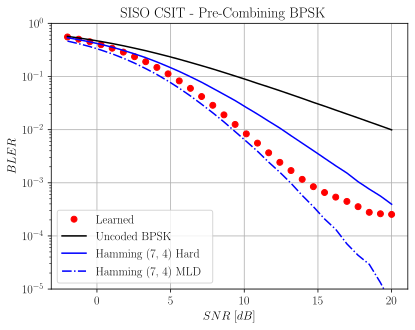

In [69]:
plt.rcParams.update({
    "text.usetex": True, # Comment this if TeX is not available in your machine
    "font.family" : 'serif',
    "font.size": 12
})
fig, axes = plt.subplots()
BLER_uncoded_precombining = [0.5684428, 0.5311236, 0.493762, 0.4558404, 0.4171428, 0.378762, 0.3408908, 0.3059336, 0.271428, 0.2400552, 0.210732, 0.183804, 0.1598504, 0.1384896, 0.11907, 0.1020932, 0.0874284, 0.0742084, 0.0635188, 0.0540476, 0.0457924, 0.0387388, 0.0325744, 0.0276616, 0.023314, 0.0196752, 0.0166252, 0.0139868, 0.011788, 0.009902] 
BLER_coded_precombining_hard = [0.5365056, 0.4934964, 0.4483044, 0.4026564, 0.35597, 0.310084, 0.2662452, 0.2260272, 0.1878712, 0.1536716, 0.1244648, 0.098852, 0.0779424, 0.059974, 0.0460384, 0.0352164, 0.026156, 0.0195808, 0.0144304, 0.0106992, 0.007686, 0.0055644, 0.0040268, 0.0028976, 0.0020868, 0.0015252, 0.001048, 0.00076, 0.0005628, 0.0003944] 
BLER_coded_precombining_mld = [0.464462, 0.4150208, 0.3656132, 0.3149372, 0.2664712, 0.2206332, 0.1786068, 0.1408384, 0.1090332, 0.081956, 0.060166, 0.0430664, 0.0300664, 0.0207288, 0.0139748, 0.0091792, 0.0060196, 0.003918, 0.0024428, 0.0015752, 0.0009784, 0.000578, 0.0003552, 0.0002084, 0.0001328, 7.08e-05, 4.32e-05, 2.92e-05, 1.32e-05, 5.2e-06] 
BLER_learned_coded_csit = [0.554613, 0.503659, 0.45117, 0.396484, 0.340323, 0.288019, 0.23574, 0.189743, 0.148252, 0.112229, 0.082673, 0.05983, 0.041986, 0.028716, 0.018978, 0.012539, 0.008332, 0.005577, 0.003667, 0.002425, 0.001699, 0.00116, 0.000844, 0.000656, 0.000537, 0.000446, 0.000355, 0.000278, 0.000261, 0.000254]
axes.semilogy(SNR_dB, BLER_learned_coded_csit, label='Learned', color='red', marker="o", ls=" ")
axes.semilogy(SNR_dB, BLER_uncoded_precombining, label='Uncoded BPSK', color='black')
axes.semilogy(SNR_dB, BLER_coded_precombining_hard, label='Hamming (7, 4) Hard', color='blue')
axes.semilogy(SNR_dB, BLER_coded_precombining_mld, label='Hamming (7, 4) MLD', color='blue', ls="-.")
axes.set_xlabel(r'$SNR\ [dB]$')
axes.set_ylabel(r'$BLER$')
axes.set_ylim(10**-5, 10**0)
axes.set_title(f'SISO CSIT - Pre-Combining BPSK')
axes.legend()
axes.grid()

In [72]:
# Saving the results for future reference :
# Plot : 
fig.savefig("plots/deepSISOCSIT.svg", transparent=True)
# BLER points :
with open(file="results/deepSISOCSIT.txt", mode='w') as file_id:
    file_id.write(f'BLER_learned_coded_csit = {BLER_learned_coded_csit}\n')
    file_id.write(f'BLER_uncoded_precombining = {BLER_uncoded_precombining}\n')
    file_id.write(f'BLER_coded_precombining_hard = {BLER_coded_precombining_hard}\n')
    file_id.write(f'BLER_coded_precombining_mld = {BLER_coded_precombining_mld}\n')